# UCM analysis

2018-08-23

In [ ]:
%matplotlib inline
import ipdb as pdb
import os
import matplotlib.pyplot as plt
# import mpl_toolkits.mplot3d.art3d as art3d

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.embed import embed_minimal_html
import ipywidgets as widgets
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

import pandas as pd
import numpy as np
import numdifftools as nd
# from tools.utils import *
from time import gmtime, strftime
import tensorflow as tf
from train import *
from utils import *

## Load data

In [34]:
params = get_param('model/test', which_epoch=2000)  # model parameters
phn2idx = np.load('phn2idx.npy').item()
idx2phn = np.load('idx2phn.npy').item()
pca = np.load('fft_linfilt_pca.npy').item()
labels = np.load('labels.npy')
X_reduced = np.load('fft_linfilt_pca_reduced.npy')
X_scaler = np.load('fft_linfilt_pca_reduced_scaler.npy').item()
X_std = X_scaler.transform(X_reduced)
phones = [*phn2idx]

model_dir: model/test
which_epoch: 2000
INFO:tensorflow:Restoring parameters from model/test/model_epoch=2000


In [35]:
X_std.shape

(38777, 15)

In [15]:
vowels = ['IY1','AE1','AA1','UW1']

In [44]:
# Get vowel reference
meanAcous = np.zeros((len(vowels),15))
for i, v in enumerate(vowels):
    idx, _ = find_elements(v, labels)
    meanAcous[i,:] = np.mean(X_std[idx,:], axis=0)

In [45]:
meanAcous.shape

(4, 15)

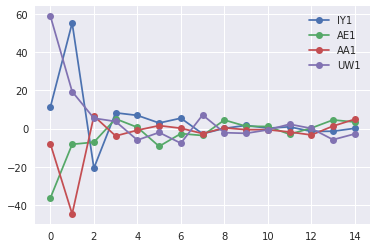

In [46]:
fig, ax = plt.subplots(facecolor='white')
p = ax.plot(X_scaler.inverse_transform(meanAcous).T, 'o-');
ax.legend(vowels)

## Choose your vowel

In [47]:
which_vowel = 'IY1'
idx, _ = find_elements(which_vowel, vowels)
print('meanAcousV:', meanAcous)
print('Init PCs:', init_pcs)

## Get Jacobian

In [58]:
def forward(X):
    '''
    This function requires ANN hyper-parameters and sigmoid function
    from outside.
    They were separated for calculating Jacobian matrix (numdifftools)
    '''
    W1, W2, W3, W4 = params['W1'], params['W2'], params['W3'], params['W4']
    b1, b2, b3, b4 = params['b1'], params['b2'], params['b3'], params['b4']
    L1 = relu(np.dot(X, W1) + b1) # Nx300
    L2 = relu(np.dot(L1, W2) + b2) # Nx300
    L3 = relu(np.dot(L2, W3) + b3) # Nx300
    L4 = relu(np.dot(L3, W4) + b4) # Nx3000
    return softmax(L4)

In [58]:
jacob = nd.Jacobian(forward)
J = jacob(np.squeeze(meanAcous[idx]))
print('Shape=', J.shape)

Shape= (9, 15)


In [59]:
# Null space of Jacobian
ucm_vec = nullspace(J)
print('Shape=', ucm_vec.shape)
print(ucm_vec)

Shape= (15, 9)
[[ 3.24182196e-01 -3.76633504e-01 -1.29030437e-01 -3.32937629e-03
  -2.80609336e-01  4.80589135e-02 -2.04371282e-01  2.04303784e-02
   4.85664564e-02]
 [-1.04998880e-01  1.07116625e-01 -9.38283479e-02 -3.28731977e-02
  -5.78957888e-03 -2.83512299e-01  1.45281048e-01  1.40093239e-01
   1.47880262e-01]
 [-8.19220289e-02  6.15300715e-02 -2.97827860e-01  1.96533729e-01
   2.32678872e-01 -4.31230131e-01  4.36465073e-01  5.01472472e-02
   4.06115708e-01]
 [-1.04911113e-01  1.06854328e-02  3.00292847e-01  1.23284302e-01
   2.09732741e-01 -1.99191627e-01  5.40018512e-02 -2.45407078e-01
  -3.78693559e-01]
 [-2.90274532e-01 -4.56173843e-01 -2.24825729e-01  6.66961650e-02
  -1.99940115e-01  2.46494874e-01  5.99821529e-02 -2.80491286e-01
   1.38861666e-01]
 [-5.38179451e-01 -2.80345350e-01  4.37068821e-01 -2.40937993e-01
  -2.18182372e-02 -2.14412408e-01 -2.01035252e-02  2.75119671e-01
  -6.80669309e-02]
 [ 3.45052140e-01 -2.42638117e-01 -2.76328921e-01 -2.68609067e-01
  -8.85970165

## 이것은 무엇??? Null space가 전체스페이스?!

- Raw -> Scale -> PCA -> ANN으로 가는 과정을 다시 할 것! (특히 Scale -> PCA !!)
- 리얼타임 플랏팅 확인할 것
- Jacobian, UCM space 확인할 것

## UCM analysis

## CM analysis